In [1]:
from Dataset.dataset import Eve, Flchain, FlchainSub1
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
import pickle
from model import XSurvKMeansRF
import time
import pandas as pd
import matplotlib.pyplot as plt

import shap

C:\Users\Abd\AppData\Local\conda\conda\envs\hh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = FlchainSub1('Dataset/flchain.csv')

Dataset Description =======================
Dataset Name: flchain_sub1
Dataset Shape: (7874, 6)
Events: 27.55 %
NaN Values: 2.86 %
Events % in splits: 27.56, 27.56, 27.56, 27.56, 27.51, 



In [3]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)
 #train_df_orig, val_df_orig, test_df_orig) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print('Testing on %d-----------------------------' % 1)
print(x_train.shape, x_val.shape)

Testing on 1-----------------------------
(4724, 4) (1575, 4)


In [4]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape, y_val_surv.shape)

# train RSF
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=20,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           oob_score=True,
                           n_jobs=-1,
                           random_state=20)
rsf.fit(x_train, y_train_surv)

(4724,) (1575,)


RandomSurvivalForest(max_features='sqrt', min_samples_leaf=10,
                     min_samples_split=20, n_estimators=50, n_jobs=-1,
                     oob_score=True, random_state=20)

In [5]:
#pickle.dump(rsf, open('rsf_model_eve.mdl', 'wb'))
#rsf = pickle.load(open('rsf_model_eve.mdl', 'rb'))

In [6]:
cindex_train = rsf.score(x_train, y_train_surv)
cindex_oob = rsf.oob_score_
cindex_val = rsf.score(x_val, y_val_surv)
cindex_test = rsf.score(x_test, y_test_surv)

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Val cindex {:.2f}'.format(cindex_val*100))
print('Test cindex {:.2f}'.format(cindex_test*100))
print('oob cindex {:.2f}'.format(cindex_oob*100))

Train cindex 85.82
Val cindex 79.09
Test cindex 76.79
oob cindex 78.91


In [7]:
surv_train = rsf.predict_survival_function(x_train, return_array=True)
surv_val = rsf.predict_survival_function(x_val, return_array=True)
surv_test = rsf.predict_survival_function(x_test, return_array=True)



#Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

survival_curves = (surv_train, surv_val, surv_test)

shape: 1151


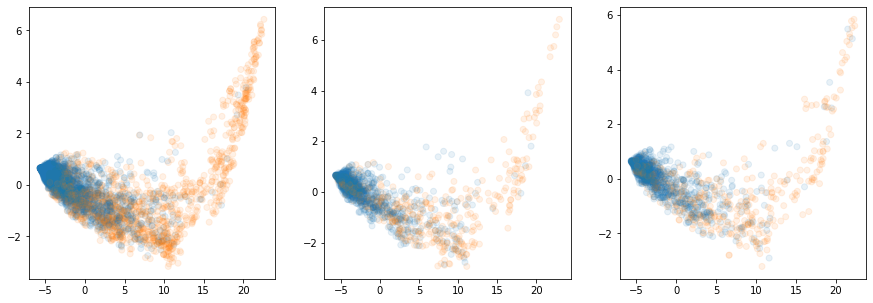

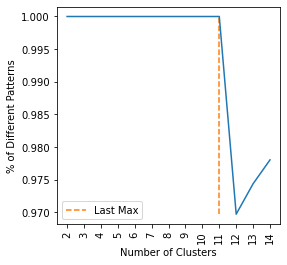

<Figure size 360x360 with 0 Axes>

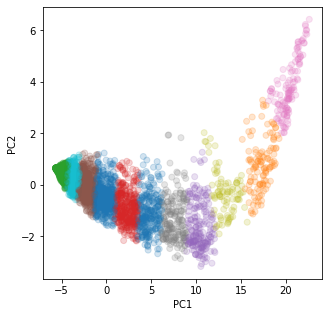

<Figure size 360x360 with 0 Axes>

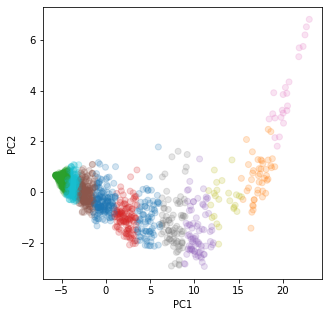

<Figure size 360x360 with 0 Axes>

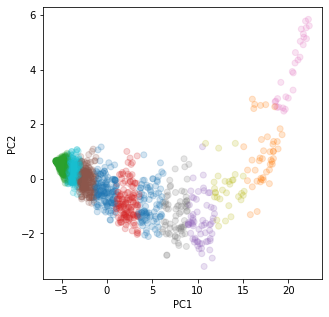

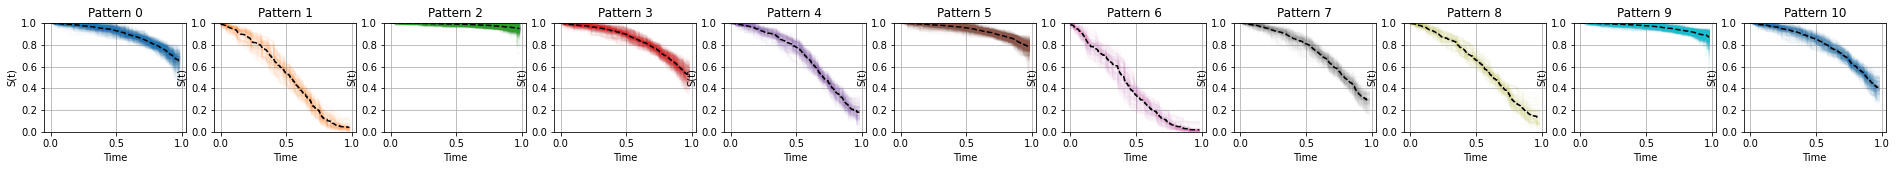

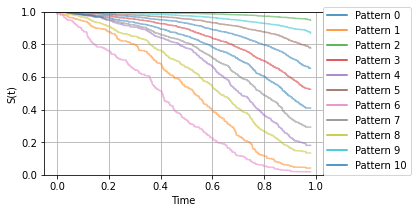

In [8]:
explainer = XSurvKMeansRF(prefix_name='flchain_sub1', max_k=15, z_explained_variance_ratio_threshold=0.99, curves_diff_significance_level=0.05, max_depth=15)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=rsf.event_times_)#, pretrained_clustering_model="clustering_model_eve_9_20220223-152051.mdl", k=9)

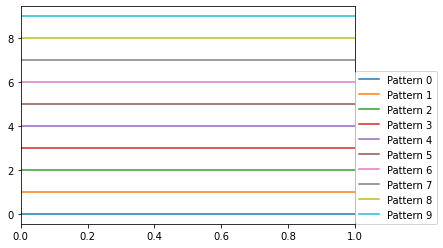

In [12]:
for i in range(10):
    plt.axhline(i, c=f'C{i}', label=f'Pattern {i}')
plt.legend(loc=(1, 0))

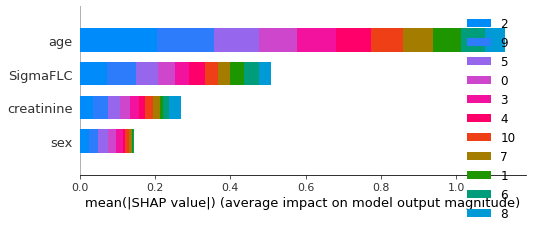

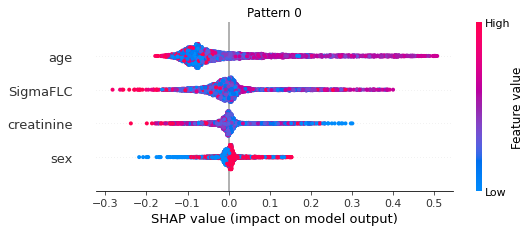

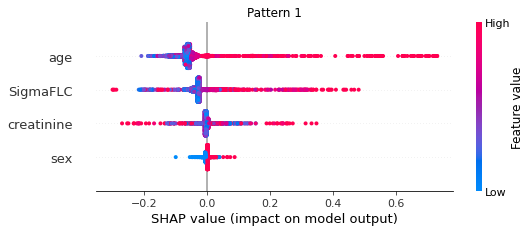

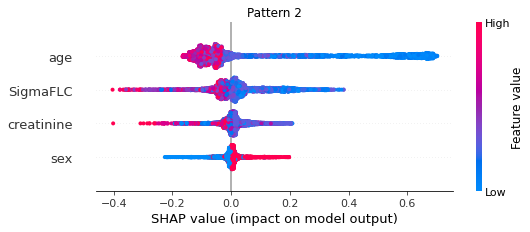

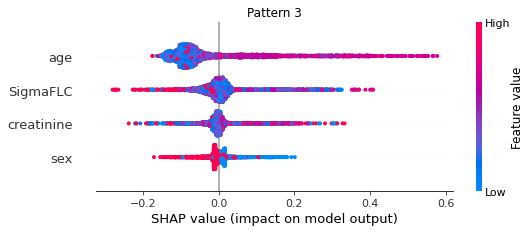

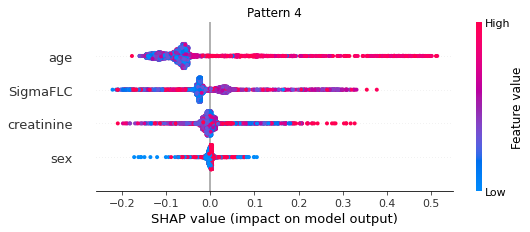

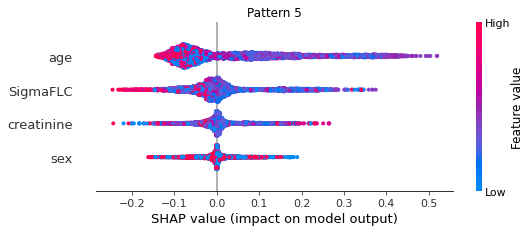

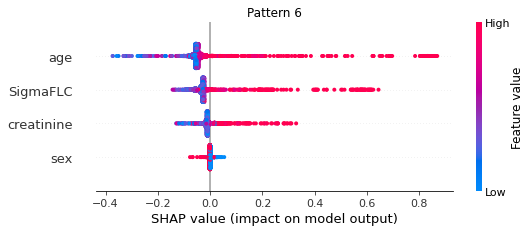

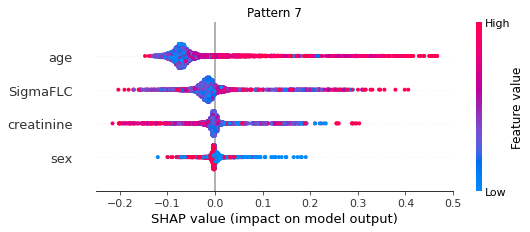

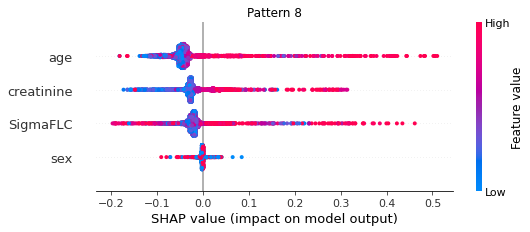

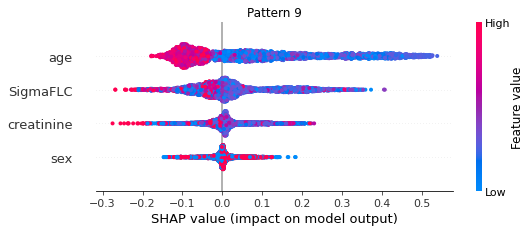

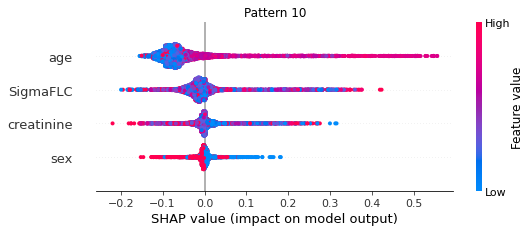

In [9]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train')

In [10]:
risk_group = 6

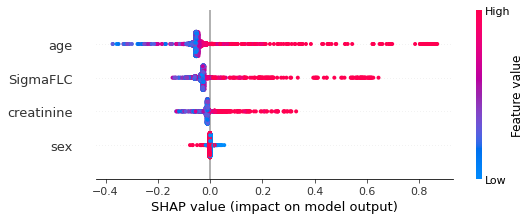

In [11]:
shap.summary_plot(explainer.shap_values[risk_group], x_train, feature_names=ds.features_names, show=False)

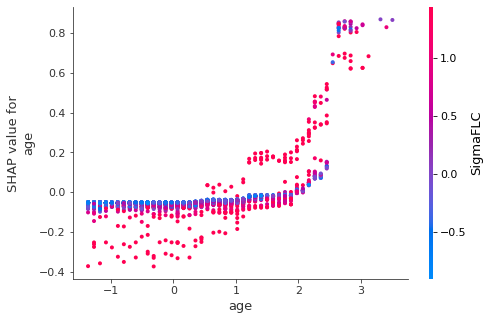

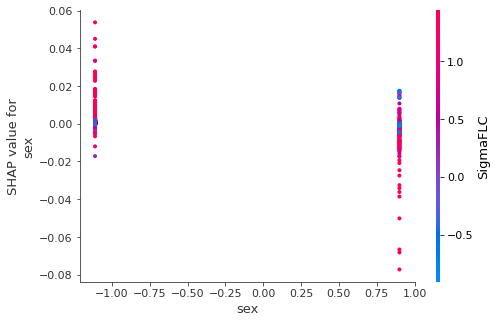

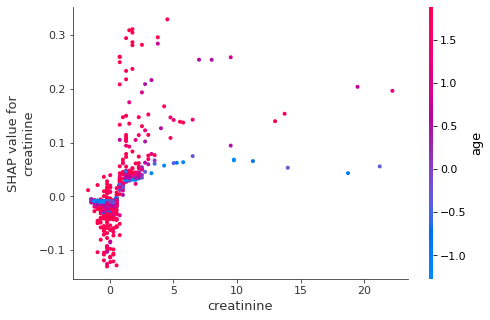

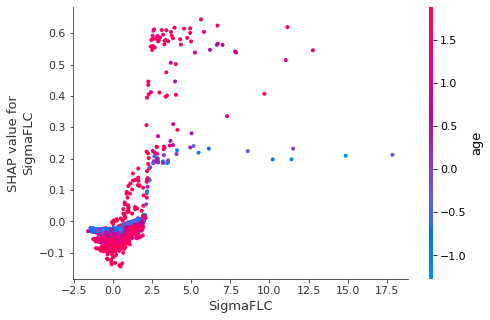

In [12]:
for i in range(len(ds.features_names)):
    shap.dependence_plot(i, explainer.shap_values[risk_group], x_train, feature_names=ds.features_names)

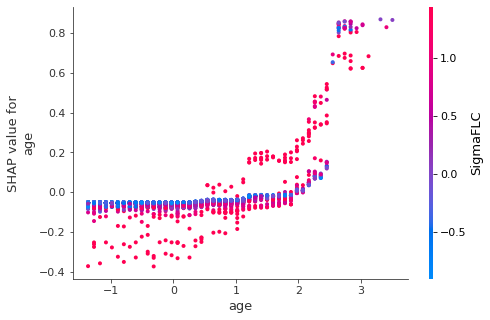

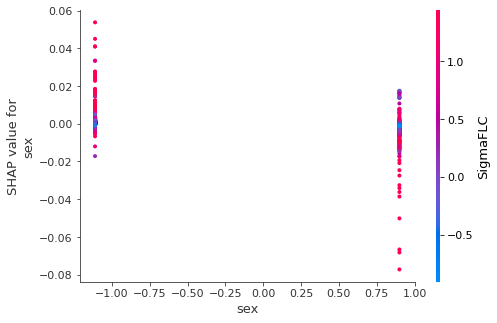

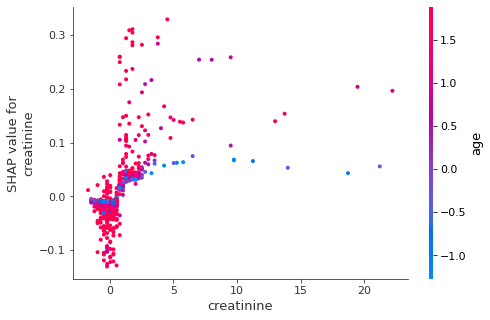

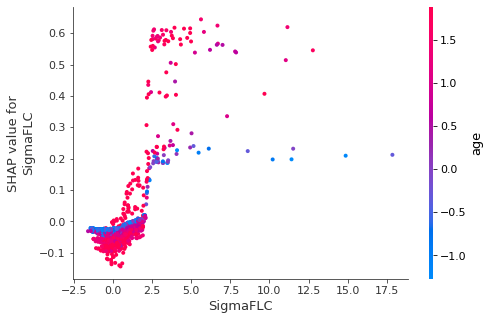

In [13]:
for i in range(len(ds.features_names)):
    shap.dependence_plot(i, explainer.shap_values[risk_group], x_train, feature_names=ds.features_names, show=False)
    plt.savefig(f"Results/flchain_sub1/{ds.features_names[i]}.pdf")

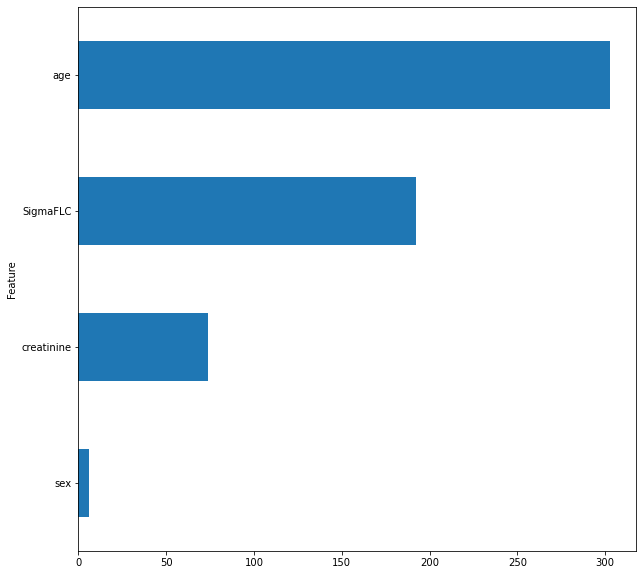

In [14]:
feature_importnce_df = pd.DataFrame(zip(ds.features_names, np.abs(explainer.shap_values[risk_group]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

feature_importnce_df['Color'] = feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
feature_importnce_df['Abs_Imp'] = feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=feature_importnce_df.sort_values('Abs_Imp')['Color'])

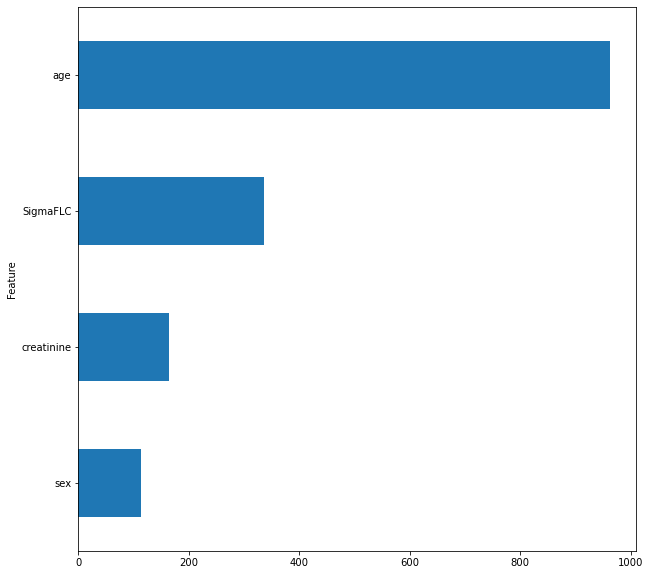

In [17]:
feature_importnce_df = pd.DataFrame(zip(ds.features_names, np.abs(explainer.shap_values[2]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

feature_importnce_df['Color'] = feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
feature_importnce_df['Abs_Imp'] = feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=feature_importnce_df.sort_values('Abs_Imp')['Color'])

In [15]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [16]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')